In [1]:
import os

os.chdir('app/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
path_to_data = 'data'

In [4]:
df_train = pd.read_parquet(path_to_data + '/train_dataset_hackaton2023_train.gzip')
df_test = pd.read_parquet(path_to_data + '/hackaton2023_test.gzip')

df_test['date_diff_post'] = 0
df_test['buy_post'] = 0

In [5]:
def generate_pivot_features(df, col, value, aggfunc):
    pivot = df.pivot_table(values=[value], index=['customer_id'], columns=[col], aggfunc=aggfunc)
    pivot.columns = [f'{col}_{v}_{value}_{aggfunc}' for _, v in pivot.columns]
    pivot = pivot.reset_index()

    return pivot

In [6]:
def has_ws(x):
    return x in ['Отдельно стоящий с внешней зоной', 'Отдельно стоящий без внешней зоны', 'Отдельно стоящий', 'Фудкорт с туалетом']

def is_food_court(x):
    return 'Фудкорт' in x

In [7]:
def preprocess(df):
    # df = df.drop_duplicates()

    df['discounts'] = df['revenue'] == 1
    df['has_ws'] = df['format_name'].apply(has_ws)
    df['is_food_court'] = df['format_name'].apply(is_food_court)

    data_check_agg = df.groupby(['customer_id', 'startdatetime']).agg({
        'revenue': ['sum', 'count'], 
        'discounts': 'sum',
        'has_ws': 'first',
        'is_food_court': 'first',
        'buy_post': 'first',
        'date_diff_post': 'first',
    }).reset_index()

    data_check_agg.columns = [f'{header}_{stat}' if header == 'revenue' else header for header, stat in data_check_agg.columns]
    data_check_agg = data_check_agg.rename({'revenue_sum': 'revenue', 'revenue_count': 'positions_count'}, axis=1)

    data_check_agg['delta'] = data_check_agg.groupby('customer_id')['startdatetime'].diff() 

    data_check_agg['delta_hours'] = (data_check_agg['delta'].dt.total_seconds() // (60*60)).fillna(0)
    data_check_agg['delta_days'] = (data_check_agg['delta'].dt.total_seconds() // (24*60*60)).fillna(0)

    data_check_agg = data_check_agg.drop('delta', axis=1)
    data_check_agg['month'] = data_check_agg['startdatetime'].dt.month
    data_check_agg['day_of_week'] = data_check_agg['startdatetime'].dt.day_of_week
    data_check_agg['hour'] = data_check_agg['startdatetime'].dt.hour

    data_cust_agg = data_check_agg.groupby('customer_id').agg({
        'revenue': ['mean', 'median', 'std', 'max', 'min', 'count'],
        'positions_count': ['mean', 'median', 'std', 'max', 'min'],
        'discounts': ['mean', 'median', 'std', 'max', 'min'],
        'delta_hours': ['mean', 'median', 'std', 'max'],
        'delta_days': ['mean', 'median', 'std', 'max'],
        'hour': ['mean', 'median', 'std', 'max', 'min'],
        'startdatetime': ['min', 'max'],
        'has_ws': 'mean',
        'is_food_court': 'mean',
        'buy_post': 'first',
        'date_diff_post': 'first',
    }).reset_index()

    data_cust_agg.columns = [f'{header}_{stat}' for header, stat in data_cust_agg.columns]

    data_cust_agg['recency'] = (data_cust_agg['startdatetime_max'] - data_cust_agg['startdatetime_min']).dt.days
    data_cust_agg['T'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_min']).dt.days
    data_cust_agg['days_from_last_purchase'] = (pd.to_datetime('2023-08-02') - data_cust_agg['startdatetime_max']).dt.days
    data_cust_agg['lambda'] = data_cust_agg['revenue_count'] / (data_cust_agg['recency'] + 1)
    data_cust_agg = data_cust_agg.drop(['startdatetime_min', 'startdatetime_max'], axis=1)
    
    return data_cust_agg

In [8]:
data_train_val = preprocess(df_train)

In [9]:
data_train_val.head()

,customer_id_,revenue_mean,revenue_median,revenue_std,revenue_max,revenue_min,revenue_count,positions_count_mean,positions_count_median,positions_count_std,...,hour_max,hour_min,has_ws_mean,is_food_court_mean,buy_post_first,date_diff_post_first,recency,T,days_from_last_purchase,lambda
0,29891,203.494000,199.960,123.170275,439.98,1.00,25,1.360000,1.0,0.860233,...,19,0,1.000000,0.000000,1,9.0,57,239,181,0.431034
1,30477,227.024000,229.990,124.933425,499.95,44.99,25,2.440000,1.0,1.916594,...,16,8,1.000000,0.000000,1,10.0,51,301,249,0.480769
2,31426,391.399583,344.985,334.849322,1079.97,1.00,24,3.583333,3.5,1.909169,...,22,9,0.000000,1.000000,1,4.0,50,81,31,0.470588
3,44491,128.725000,59.980,144.471912,344.97,49.97,4,2.500000,2.5,0.577350,...,22,18,0.000000,0.250000,1,42.0,27,52,24,0.142857
4,44939,554.943333,554.940,49.985000,604.93,504.96,3,8.333333,9.0,1.154701,...,22,11,0.333333,0.666667,1,9.0,15,234,219,0.187500


In [10]:
data_test = preprocess(df_test)

In [11]:
data_test.head()

,customer_id_,revenue_mean,revenue_median,revenue_std,revenue_max,revenue_min,revenue_count,positions_count_mean,positions_count_median,positions_count_std,...,hour_max,hour_min,has_ws_mean,is_food_court_mean,buy_post_first,date_diff_post_first,recency,T,days_from_last_purchase,lambda
0,52341,563.942500,549.95,65.700330,655.93,499.94,4,7.000000,7.0,0.816497,...,14,13,1.000000,0.000000,0,0,32,178,146,0.121212
1,69175,430.306667,399.98,62.142941,554.96,374.98,9,5.444444,6.0,0.726483,...,21,8,1.000000,0.000000,0,0,34,40,5,0.257143
2,73427,254.240323,169.98,218.360745,869.95,1.00,31,2.064516,1.0,2.112431,...,23,0,0.935484,0.129032,0,0,58,212,153,0.525424
3,134577,372.970000,290.98,310.195853,799.93,109.99,4,3.000000,2.0,2.708013,...,20,16,0.000000,1.000000,0,0,5,316,310,0.666667
4,156357,558.963333,644.96,245.551523,749.95,281.98,3,4.333333,5.0,1.154701,...,17,10,1.000000,1.000000,0,0,43,227,184,0.068182


In [12]:
# data_train, data_valid = train_test_split(data_train_val, test_size=.2, random_state=42)

In [13]:
# data_valid_us = pd.concat([data_valid[data_valid['buy_post_first']==0], data_valid[data_valid['buy_post_first']==1].sample(6981)], axis=0)

In [14]:
X_train = data_train_val.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)
y_train_class = data_train_val['buy_post_first']
y_train_reg = data_train_val['date_diff_post_first']

X_test = data_test.drop(['date_diff_post_first', 'buy_post_first', 'customer_id_'], axis=1)

In [15]:
model_class = LGBMClassifier(
    n_estimators=1000, 
    reg_alpha=20, 
    max_depth=3, 
    importance_type='gain', 
    reg_lambda=20, 
    class_weight={0: 0.7, 1:0.3},
    verbose=-1,
)

res = cross_val_score(model_class, X_train, y_train_class, scoring='roc_auc')
print(f'ROC-AUC: {res.mean():.3f} ± {res.std():.3f}')

ROC-AUC: 0.751 ± 0.000


In [16]:
model_class.fit(X_train, y_train_class)

LGBMClassifier(class_weight={0: 0.7, 1: 0.3}, importance_type='gain',
               max_depth=3, n_estimators=1000, reg_alpha=20, reg_lambda=20,
               verbose=-1)

<Axes: >

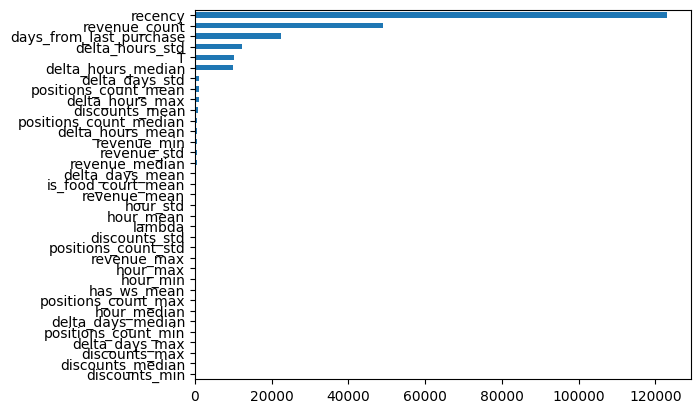

In [17]:
pd.Series(model_class.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh')

In [22]:
model_reg = LGBMRegressor(
    n_estimators=1000, 
    reg_alpha=20, 
    max_depth=3, 
    importance_type='gain', 
    reg_lambda=20,
    verbose=-1,
)

res = cross_val_score(model_reg, X_train, y_train_reg.fillna(0), scoring='neg_root_mean_squared_error')
print(f'RMSE: {-res.mean():.3f} ± {res.std():.3f}')

RMSE: 16.673 ± 0.207


In [35]:
model_reg.fit(X_train, y_train_reg.fillna(0))

LGBMRegressor(importance_type='gain', max_depth=3, n_estimators=1000,
              reg_alpha=20, reg_lambda=20, verbose=-1)

In [36]:
pred_class = model_class.predict(X_test)
pred_reg = model_reg.predict(X_test)

In [38]:
sub = pd.DataFrame()

sub['customer_id'] = data_test['customer_id_']
sub['date_diff_post'] = pred_reg
sub['buy_post'] = pred_class

In [39]:
sub.to_csv('lgbm_3.csv', sep=';', index=False)